In [ ]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

<h1>Diabetes Dataset</h1>

In [ ]:
df = pd.read_csv(r'/kaggle/input/pima-indians-diabetes-database/diabetes.csv')

In [ ]:
df.head()

<h1>Quick Data Cleaning</h1>

In [ ]:
X = df[df.columns[:-1]]
y = df['Outcome']
print('*********X*********')
print(X)
print('*********y*********')
print(y)

In [ ]:
X = torch.tensor(X.values)
y = torch.tensor(y.values)
print('*********X*********')
print(X)
print('*********y*********')
print(y)

In [ ]:
def log_loss(y, y_pred): ##log loss error (binary cross entropy)
  return -torch.sum((y*torch.log(y_pred) + (1-y)*torch.log(1-y_pred)))/y.shape[0]

def sigmoid(linear):
    return 1/(1+torch.exp(-linear))

<h1>Normalizing the Data</h1>

In [ ]:
X_mean = torch.mean(X, axis=0)
X_std = torch.std(X, axis=0)
X = (X-X_mean)/X_std
X = torch.cat((X, torch.ones(X.shape[0], dtype=float).reshape(-1,1)), dim=1)

<h1>Vectorization</h1>

In [ ]:
epoch_loss = []

weights = torch.zeros(9, dtype=float, requires_grad=True)
learning_rate = 1e-1 
n = X.shape[0]

for epoch in range(1000+1): 
    linear = weights.reshape(1,-1)@X.T ##one equation for all
    y_pred =  sigmoid(linear) ##logistic
    loss = log_loss(y, y_pred)
    epoch_loss.append(loss.item())

    ###backpropagation###
    loss.backward()

    ###step###
    with torch.no_grad():
        weights -= learning_rate * weights.grad

    weights.grad.zero_()

    if(epoch % 100 == 0):
        acc = torch.sum(((y_pred>=0.5)+0 == y)+0).item()/y.shape[0]
        print('epoch: {0} - loss: {1:.5f}; acc: {2:.3f}'.format(epoch, epoch_loss[-1], acc))

In [ ]:
plt.plot(epoch_loss)

<h1>Neural Network Architecture</h1>

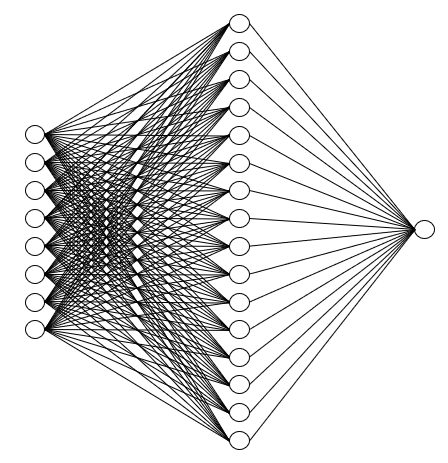

In [ ]:
def accuracy(y_pred, y):
    return torch.sum((((y_pred>=0.5)+0).reshape(1,-1)==y)+0).item()/y.shape[0]

In [ ]:
hidden_nodes = 16
torch.random.manual_seed(1234)
hidden_weights = torch.rand((hidden_nodes, 9), dtype=float, requires_grad=True)
torch.random.manual_seed(1234)
output_weights = torch.rand((1, hidden_nodes), dtype=float, requires_grad=True)

In [ ]:
epoch_loss = []

learning_rate = 1e-1
n = X.shape[0]

for epoch in range(100000+1): 
    ##hidden layer##
    hidden_linear = hidden_weights@X.T
    hidden_output = sigmoid(hidden_linear)
    ################
    output_linear = output_weights@hidden_output
    y_pred = sigmoid(output_linear)
    loss = log_loss(y, y_pred)
    epoch_loss.append(loss.item())

    ###backpropagation###
    loss.backward()

    ###step###
    with torch.no_grad():
        hidden_weights -= learning_rate * hidden_weights.grad
        output_weights -= learning_rate * output_weights.grad

    hidden_weights.grad.zero_()
    output_weights.grad.zero_()

    if(epoch % 10000 == 0):
        print('epoch: {0} - loss: {1:.5f}; acc: {2:.3f}'.format(epoch, epoch_loss[-1], accuracy(y_pred, y)))

In [ ]:
plt.plot(epoch_loss)

<h1>Using torch.nn</h1>

In [ ]:
import torch.nn as nn

In [ ]:
class Model(nn.Module):
    
    def __init__(self, nodes):
        super().__init__()
        self.hidden_linear = nn.Linear(8, nodes)
        self.output_linear = nn.Linear(nodes, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X):
        hidden_output = self.sigmoid(self.hidden_linear(X))
        out = self.sigmoid(self.output_linear(hidden_output))
        return out

In [ ]:
hidden_nodes = 16
model = Model(hidden_nodes)
log_loss = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1)

In [ ]:
model.train()
epoch_loss = []

for epoch in range(100000+1):
    y_pred = model(X[:,:-1].float())
    loss = log_loss(y_pred, y.reshape(-1,1).float())
    epoch_loss.append(loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if(epoch % 10000 == 0):
        print('epoch: {0} - loss: {1:.5f}; acc: {2:.3f}'.format(epoch, epoch_loss[-1], accuracy(y_pred, y)))

In [ ]:
plt.plot(epoch_loss)